In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from wearsed.dataset.CFSDataset import CFSDataset
from wearsed.training.metric import correct, to_event_list

In [2]:
dataset = CFSDataset(cfs_id_path='../wearsed/dataset/data_ids/')
cfs_harmonized = pd.read_csv('/vol/sleepstudy/datasets/cfs/datasets/cfs-visit5-harmonized-dataset-0.7.0.csv').set_index('nsrrid')

In [3]:
preds = pd.read_csv('../wearsed/evaluation/output/predictions.csv', header=None)[0]

In [4]:
preds[preds > 100].index

Index([       0,    36961,    72242,   105843,   139444,   174725,   210006,
         241927,   273848,   299049,
       ...
       10540634, 10572555, 10611196, 10639757, 10671678, 10706959, 10743920,
       10777521, 10811122, 10848083],
      dtype='int64', length=324)

In [4]:
def get_individual(all_preds):
    individual_preds = []
    start_idxs = list(preds[preds > 100].index)
    for start, end in zip(start_idxs, start_idxs[1:] + [len(preds)]):
        individual_preds.append(preds[start+1:end])
    return individual_preds

def get_tst(hypnogram):
    awake_phases = hypnogram[hypnogram != 0]
    tst_in_sec = len(awake_phases)
    return tst_in_sec / 60 / 60  # TST in hours

def get_ahis(all_preds, dataset, thr=0.25):
    predictions = get_individual(all_preds)

    ahis_pred, ahis_true = [], []
    ages, bmis = [], []
    for i in tqdm(range(len(dataset))):
        (hypnogram, _, _), cfs_id = dataset[i]
        tst = get_tst(hypnogram)
        ahi_true = float(cfs_harmonized.loc[cfs_id]['nsrr_ahi_hp3r_aasm15'])
        ahis_true.append(ahi_true)
        ages.append(float(cfs_harmonized.loc[cfs_id]['nsrr_age']))
        bmis.append(float(cfs_harmonized.loc[cfs_id]['nsrr_bmi']))

        y_pred = predictions[i]
        y_pred = (y_pred > thr)*1
        y_pred_list = to_event_list(correct(y_pred, size=3))
        ahi_pred = len(y_pred_list) / tst
        ahis_pred.append(ahi_pred)
    return ahis_pred, ahis_true, ages, bmis

In [6]:
ahis_pred, ahis_true, ages, bmis = get_ahis(preds, dataset)

100%|██████████| 324/324 [07:19<00:00,  1.36s/it]


In [7]:
print(ahis_true[:4])
print(ahis_pred[:4])
print(ages[:4])

[2.98, 9.17, 21.18, 39.56]
[21.16770186335404, 22.746051032806804, 52.85481239804241, 41.0625]
[38.75, 22.5, 57.26, 60.66]


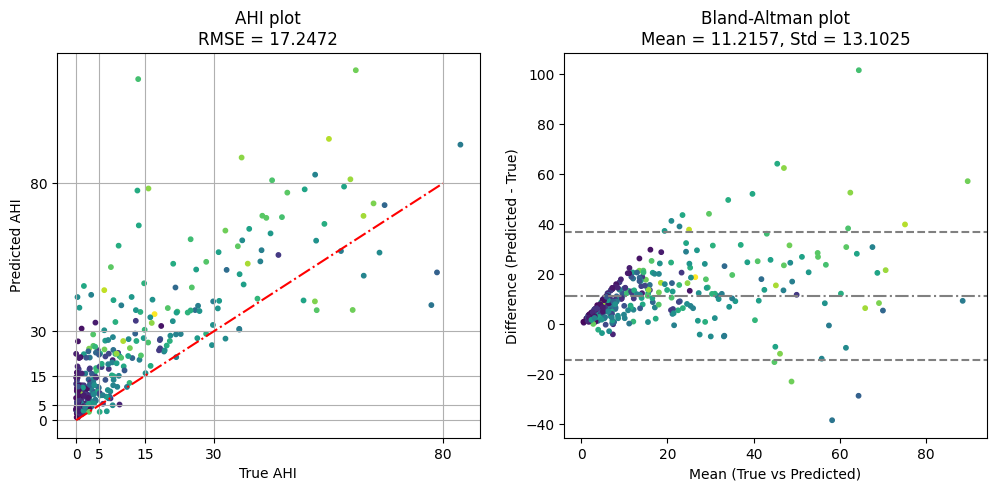

In [8]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(ahis_true, ahis_pred, s=10, c=np.array(ages)/100)
ax1.plot([0, 80], [0, 80], 'r-.')
ax1.set_title(f'AHI plot\nRMSE = {np.sqrt(((np.array(ahis_pred) - np.array(ahis_true)) ** 2).mean()):.4f}')
ax1.set_xlabel('True AHI')
ax1.set_ylabel('Predicted AHI')
ax1.set_xticks([0, 5, 15, 30, 80])
ax1.set_yticks([0, 5, 15, 30, 80])
ax1.grid()

mean = np.mean([ahis_pred, ahis_true], axis=0)
diff = np.array(ahis_pred) - np.array(ahis_true)
diff_mean, diff_std = np.mean(diff), np.std(diff, axis=0)
ax2.scatter(mean, diff, s=10, c=np.array(ages)/100)
ax2.axhline(diff_mean,                 color='gray', linestyle='-.')
ax2.axhline(diff_mean + 1.96*diff_std, color='gray', linestyle='--')
ax2.axhline(diff_mean - 1.96*diff_std, color='gray', linestyle='--')
ax2.set_title(f'Bland-Altman plot\nMean = {diff_mean:.4f}, Std = {diff_std:.4f}')
ax2.set_xlabel('Mean (True vs Predicted)')
ax2.set_ylabel('Difference (Predicted - True)')

plt.show()

In [9]:
pd.Series(ages).describe()

count    324.000000
mean      39.504198
std       19.621924
min        7.290000
25%       21.092500
50%       42.150000
75%       54.397500
max       88.530000
dtype: float64

In [12]:
(pd.Series(ages) < 18).sum()

np.int64(65)

In [11]:
import pingouin as pg

ahi_data = pd.DataFrame({
    'subject_id': list(range(len(ahis_true)))*2,
    'raters': ['true'] * len(ahis_true) + ['pred'] * len(ahis_true),
    'ahis': ahis_true + ahis_pred
})

icc = pg.intraclass_corr(data=ahi_data, targets='subject_id', raters='raters', ratings='ahis')
icc

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.633239,4.453145,323,324,3.287167e-38,"[0.56, 0.69]"
1,ICC2,Single random raters,0.659530,7.692299,323,323,2.811125e-65,"[0.21, 0.83]"
2,ICC3,Single fixed raters,0.769911,7.692299,323,323,2.811125e-65,"[0.72, 0.81]"
3,ICC1k,Average raters absolute,0.775440,4.453145,323,324,3.287167e-38,"[0.72, 0.82]"
4,ICC2k,Average random raters,0.794840,7.692299,323,323,2.811125e-65,"[0.35, 0.91]"
5,ICC3k,Average fixed raters,0.870000,7.692299,323,323,2.811125e-65,"[0.84, 0.9]"


In [ ]:
x = pd.DataFrame({
    'ahis_true': ahis_true,
    'ahis_pred': ahis_pred,
    'ages': ages,
})

adults = x[x['ages'] >= 18]

ahis_true = list(adults['ahis_true'].values)
ahis_pred = list(adults['ahis_pred'].values)
ages = list(adults['ages'].values)

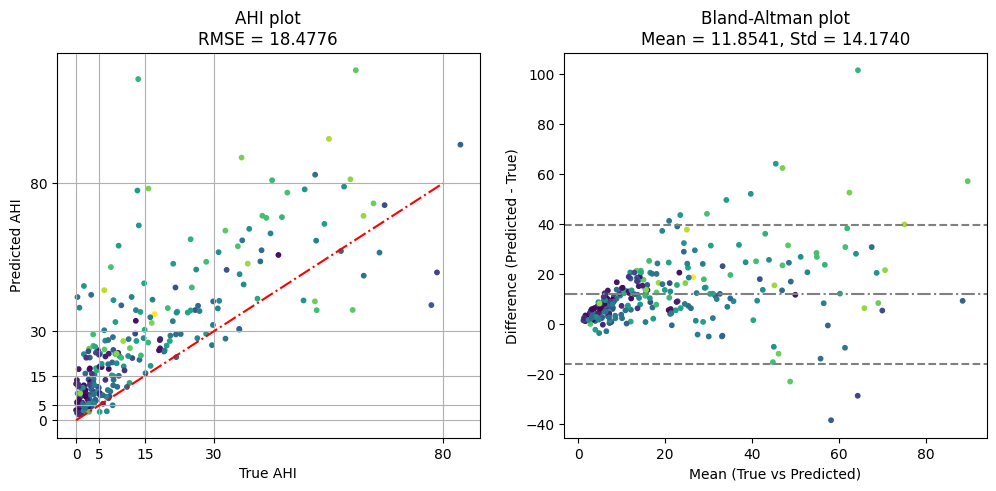

In [22]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(ahis_true, ahis_pred, s=10, c=np.array(ages)/100)
ax1.plot([0, 80], [0, 80], 'r-.')
ax1.set_title(f'AHI plot\nRMSE = {np.sqrt(((np.array(ahis_pred) - np.array(ahis_true)) ** 2).mean()):.4f}')
ax1.set_xlabel('True AHI')
ax1.set_ylabel('Predicted AHI')
ax1.set_xticks([0, 5, 15, 30, 80])
ax1.set_yticks([0, 5, 15, 30, 80])
ax1.grid()

mean = np.mean([ahis_pred, ahis_true], axis=0)
diff = np.array(ahis_pred) - np.array(ahis_true)
diff_mean, diff_std = np.mean(diff), np.std(diff, axis=0)
ax2.scatter(mean, diff, s=10, c=np.array(ages)/100)
ax2.axhline(diff_mean,                 color='gray', linestyle='-.')
ax2.axhline(diff_mean + 1.96*diff_std, color='gray', linestyle='--')
ax2.axhline(diff_mean - 1.96*diff_std, color='gray', linestyle='--')
ax2.set_title(f'Bland-Altman plot\nMean = {diff_mean:.4f}, Std = {diff_std:.4f}')
ax2.set_xlabel('Mean (True vs Predicted)')
ax2.set_ylabel('Difference (Predicted - True)')

plt.show()

In [23]:
import pingouin as pg

ahi_data = pd.DataFrame({
    'subject_id': list(range(len(ahis_true)))*2,
    'raters': ['true'] * len(ahis_true) + ['pred'] * len(ahis_true),
    'ahis': ahis_true + ahis_pred
})

icc = pg.intraclass_corr(data=ahi_data, targets='subject_id', raters='raters', ratings='ahis')
icc

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.618667,4.244761,258,259,3.120917e-29,"[0.54, 0.69]"
1,ICC2,Single random raters,0.646271,7.185847,258,258,1.247608e-49,"[0.21, 0.82]"
2,ICC3,Single fixed raters,0.755676,7.185847,258,258,1.247608e-49,"[0.7, 0.8]"
3,ICC1k,Average raters absolute,0.764415,4.244761,258,259,3.120917e-29,"[0.7, 0.82]"
4,ICC2k,Average random raters,0.785133,7.185847,258,258,1.247608e-49,"[0.35, 0.9]"
5,ICC3k,Average fixed raters,0.860838,7.185847,258,258,1.247608e-49,"[0.82, 0.89]"


### Normalized

In [3]:
preds = pd.read_csv('../wearsed/evaluation/output/normalized_ppg/predictions.csv', header=None)[0]

In [5]:
ahis_pred, ahis_true, ages, bmis = get_ahis(preds, dataset)

100%|██████████| 324/324 [07:07<00:00,  1.32s/it]


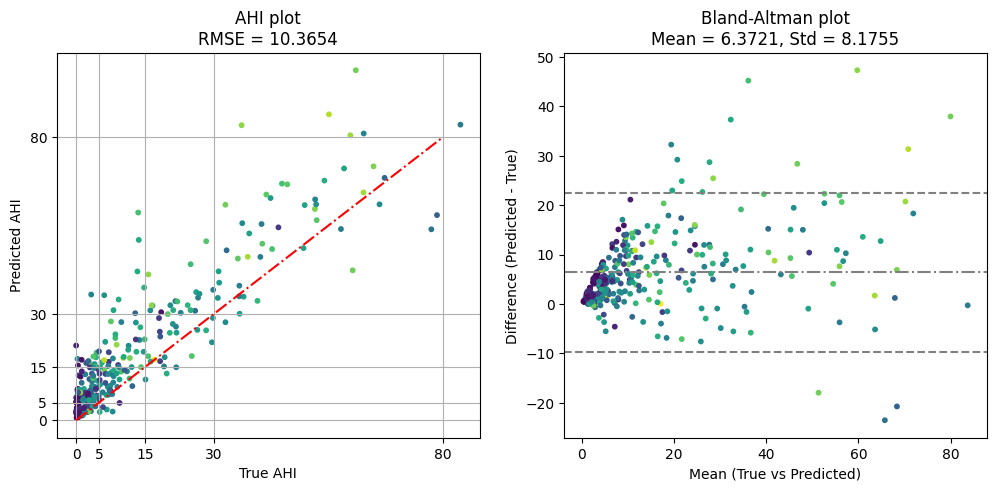

In [6]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(ahis_true, ahis_pred, s=10, c=np.array(ages)/100)
ax1.plot([0, 80], [0, 80], 'r-.')
ax1.set_title(f'AHI plot\nRMSE = {np.sqrt(((np.array(ahis_pred) - np.array(ahis_true)) ** 2).mean()):.4f}')
ax1.set_xlabel('True AHI')
ax1.set_ylabel('Predicted AHI')
ax1.set_xticks([0, 5, 15, 30, 80])
ax1.set_yticks([0, 5, 15, 30, 80])
ax1.grid()

mean = np.mean([ahis_pred, ahis_true], axis=0)
diff = np.array(ahis_pred) - np.array(ahis_true)
diff_mean, diff_std = np.mean(diff), np.std(diff, axis=0)
ax2.scatter(mean, diff, s=10, c=np.array(ages)/100)
ax2.axhline(diff_mean,                 color='gray', linestyle='-.')
ax2.axhline(diff_mean + 1.96*diff_std, color='gray', linestyle='--')
ax2.axhline(diff_mean - 1.96*diff_std, color='gray', linestyle='--')
ax2.set_title(f'Bland-Altman plot\nMean = {diff_mean:.4f}, Std = {diff_std:.4f}')
ax2.set_xlabel('Mean (True vs Predicted)')
ax2.set_ylabel('Difference (Predicted - True)')

plt.show()

In [7]:
import pingouin as pg

ahi_data = pd.DataFrame({
    'subject_id': list(range(len(ahis_true)))*2,
    'raters': ['true'] * len(ahis_true) + ['pred'] * len(ahis_true),
    'ahis': ahis_true + ahis_pred
})

icc = pg.intraclass_corr(data=ahi_data, targets='subject_id', raters='raters', ratings='ahis')
icc

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.841259,11.599169,323,324,8.510022e-89,"[0.81, 0.87]"
1,ICC2,Single random raters,0.845859,18.587907,323,323,1.966539e-117,"[0.55, 0.93]"
2,ICC3,Single fixed raters,0.897896,18.587907,323,323,1.966539e-117,"[0.87, 0.92]"
3,ICC1k,Average raters absolute,0.913787,11.599169,323,324,8.510022e-89,"[0.89, 0.93]"
4,ICC2k,Average random raters,0.916494,18.587907,323,323,1.966539e-117,"[0.71, 0.96]"
5,ICC3k,Average fixed raters,0.946202,18.587907,323,323,1.966539e-117,"[0.93, 0.96]"


In [8]:
x = pd.DataFrame({
    'ahis_true': ahis_true,
    'ahis_pred': ahis_pred,
    'ages': ages,
})

adults = x[x['ages'] >= 18]

ahis_true = list(adults['ahis_true'].values)
ahis_pred = list(adults['ahis_pred'].values)
ages = list(adults['ages'].values)

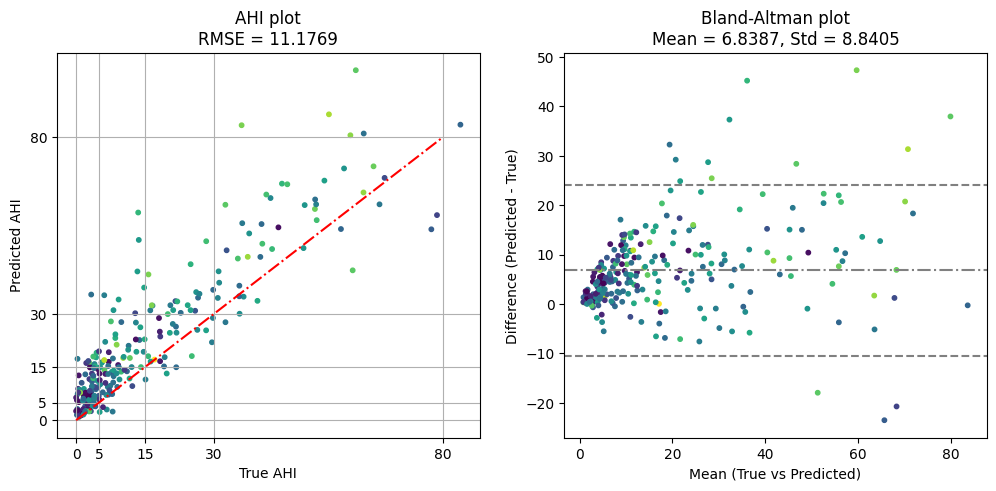

In [9]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(ahis_true, ahis_pred, s=10, c=np.array(ages)/100)
ax1.plot([0, 80], [0, 80], 'r-.')
ax1.set_title(f'AHI plot\nRMSE = {np.sqrt(((np.array(ahis_pred) - np.array(ahis_true)) ** 2).mean()):.4f}')
ax1.set_xlabel('True AHI')
ax1.set_ylabel('Predicted AHI')
ax1.set_xticks([0, 5, 15, 30, 80])
ax1.set_yticks([0, 5, 15, 30, 80])
ax1.grid()

mean = np.mean([ahis_pred, ahis_true], axis=0)
diff = np.array(ahis_pred) - np.array(ahis_true)
diff_mean, diff_std = np.mean(diff), np.std(diff, axis=0)
ax2.scatter(mean, diff, s=10, c=np.array(ages)/100)
ax2.axhline(diff_mean,                 color='gray', linestyle='-.')
ax2.axhline(diff_mean + 1.96*diff_std, color='gray', linestyle='--')
ax2.axhline(diff_mean - 1.96*diff_std, color='gray', linestyle='--')
ax2.set_title(f'Bland-Altman plot\nMean = {diff_mean:.4f}, Std = {diff_std:.4f}')
ax2.set_xlabel('Mean (True vs Predicted)')
ax2.set_ylabel('Difference (Predicted - True)')

plt.show()

In [10]:
ahi_data = pd.DataFrame({
    'subject_id': list(range(len(ahis_true)))*2,
    'raters': ['true'] * len(ahis_true) + ['pred'] * len(ahis_true),
    'ahis': ahis_true + ahis_pred
})

icc = pg.intraclass_corr(data=ahi_data, targets='subject_id', raters='raters', ratings='ahis')
icc

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.832660,10.951725,258,259,1.114313e-68,"[0.79, 0.87]"
1,ICC2,Single random raters,0.837711,17.437766,258,258,5.121896e-91,"[0.54, 0.92]"
2,ICC3,Single fixed raters,0.891527,17.437766,258,258,5.121896e-91,"[0.86, 0.91]"
3,ICC1k,Average raters absolute,0.908690,10.951725,258,259,1.114313e-68,"[0.88, 0.93]"
4,ICC2k,Average random raters,0.911689,17.437766,258,258,5.121896e-91,"[0.7, 0.96]"
5,ICC3k,Average fixed raters,0.942653,17.437766,258,258,5.121896e-91,"[0.93, 0.96]"
